# Intialize

In [5]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from classy_sz import Class
import os
import time
from scipy.integrate import simps

font = {'size'   : 16, 'family':'STIXGeneral'}
axislabelfontsize='large'
matplotlib.rc('font', **font)
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"]})


## Compute the matter power spectrum 

Let us first set the cosmological parameters


In [2]:
cosmo_params = {
 'Omega_b': 0.049,
 'Omega_cdm': 0.2685,
 'H0': 67.11,
 'sigma8': 0.834,
 'n_s': 0.9624}

Now compute with the class_sz code

In [3]:
class_sz = Class()

class_sz.set(cosmo_params)
# and output the matter power spectrum, switching off the consistency conditions

# redshift where we want the P(k)
# pick one cas, e.g, i = 0
i = 0
z = [0.2896598, 0.769316, 1.546175][i] 


# Define the minimum and maximum mass values as provided by Will Coulton
mmin = np.array([1E12, 1E13, 5E13])[i]
mmax = np.array([1E13, 5E13, 2E14])[i]


common_params = {

'output': 'mPk,pk_at_z_1h,pk_at_z_2h,dndlnm',    
"z_for_pk_hm" : z,

'z_min' : 0.005,
'z_max' : 3.0,
'M_min' : mmin, ## chosing larger masses than 1e10 seems to not give good 1-halo term
'M_max' : mmax,
    

'mass function' : 'T08M200c',
'concentration parameter' : 'B13',


'non_linear' : 'hmcode',
'hm_consistency' : 0,
    
}

class_sz.set(common_params)


True

In [4]:
%%time
class_sz.compute()

CPU times: user 35.9 s, sys: 97.1 ms, total: 36 s
Wall time: 4.95 s


## external calculation, using class_sz provided routines

We perfom this calculation externally now as shown here. 

In [8]:

# Initialize k values and redshift
nk = 500
kmin = 1e-3
kmax = 1e1
k = np.geomspace(kmin, kmax, nk)

# Mass range
nm = 250
lnm = np.linspace(np.log(mmin), np.log(mmax), nm)
m = np.exp(lnm)

In [9]:
%%time
bh = class_sz.get_first_order_bias_at_z_and_m(z, m)
dndlnm = class_sz.get_dndlnm(z, m)
uk = class_sz.get_uk(z, k, m, profile='nfw')
rho0 = class_sz.rho0_m()
u = m/rho0 * uk
pkl = class_sz.get_pk(k,z,type='lin').squeeze()

h = class_sz.h()

# comoving volume (not needed for pk)
dvdz = class_sz.get_comoving_volume(z)

pk1h = simps(dndlnm * u**2, lnm, axis=-1).squeeze()
pk2h = (simps( dndlnm * bh * u, lnm, axis=-1)**2*pkl).squeeze()

pktot = pk1h + pk2h

CPU times: user 176 ms, sys: 4.61 ms, total: 181 ms
Wall time: 183 ms


In [17]:
# pk2h

## Plot

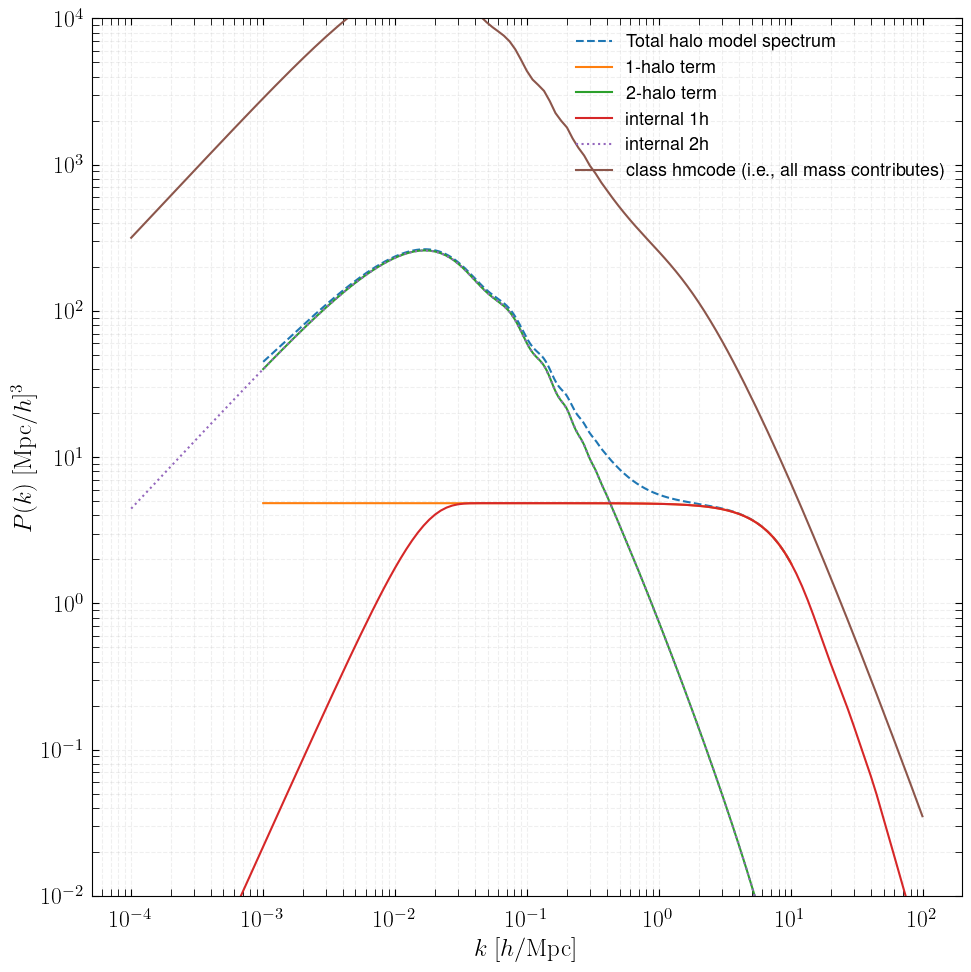

In [20]:
label_size = 17
title_size = 18
legend_size = 13
handle_length = 1.5
fig, (ax1) = plt.subplots(1,1,figsize=(10,10))


ax = ax1
ax.tick_params(axis = 'x',which='both',length=5,direction='in', pad=10)
ax.tick_params(axis = 'y',which='both',length=5,direction='in', pad=5)
ax.xaxis.set_ticks_position('both')
ax.yaxis.set_ticks_position('both')
plt.setp(ax.get_yticklabels(), rotation='horizontal', fontsize=label_size)
plt.setp(ax.get_xticklabels(), fontsize=label_size)
ax.grid( visible=True, which="both", alpha=0.2, linestyle='--')
ax.set_ylabel(r"$P(k)$    $[\mathrm{Mpc}/h]^3$",size=title_size)
ax.set_xlabel(r"$k$   $[h/\mathrm{Mpc}]$",size=title_size)
ax.set_xscale('log')
ax.set_yscale('log')

plt.loglog(k, pktot,ls='--', label='Total halo model spectrum')
plt.loglog(k, pk1h, label='1-halo term')
plt.loglog(k, pk2h, label='2-halo term')


# internal class_sz result from halo model formulas, as above but done in the C code
pk_at_z = class_sz.pk_at_z_hm()
plt.plot(pk_at_z['k'],pk_at_z['1h'],label='internal 1h')
plt.plot(pk_at_z['k'],pk_at_z['2h'],ls=':',label='internal 2h')


# internal class result from hmcode

plt.plot(pk_at_z['k'],np.vectorize(class_sz.pk)(np.asarray(pk_at_z['k'])*h,z)*h**3,label='class hmcode (i.e., all mass contributes)')



plt.ylim(1e-2,1e4)

ax.legend(fontsize=11,ncol=1,frameon=False)




ax.legend(fontsize=13,ncol=1,frameon=False)
fig.tight_layout()
